#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,train_test_split,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import fbeta_score, make_scorer,mean_squared_error


In [2]:
data=pd.read_csv('/datasets/taxi.csv',parse_dates=['datetime'])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Ресемплирование по одному часу (сумма за час)

In [5]:
data=data.resample("H",on='datetime').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

In [7]:
data.isna().sum()

num_orders    0
dtype: int64

Проверю на монотонность временной ряд.

In [8]:
data=data.sort_index()
print(data.index.is_monotonic)

True


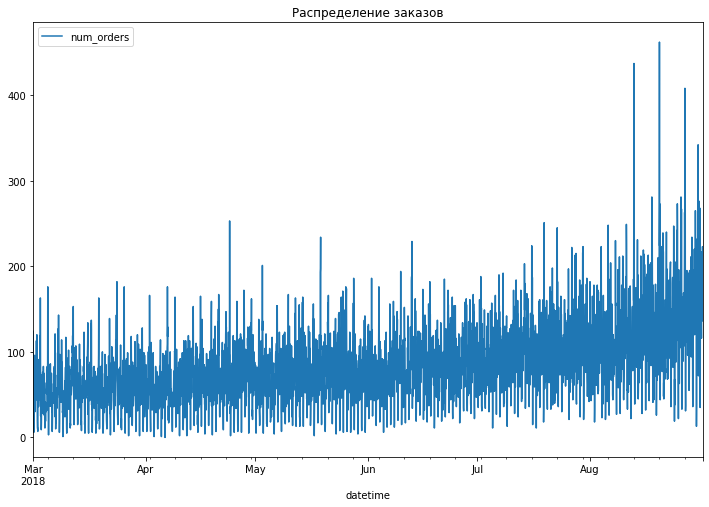

In [9]:
data.plot(figsize=(12,8))
plt.title('Распределение заказов');

Если просмотреть скользящее среднее за год, то можно посмотреть как меняются заказы в течении года и прикинуть тренд

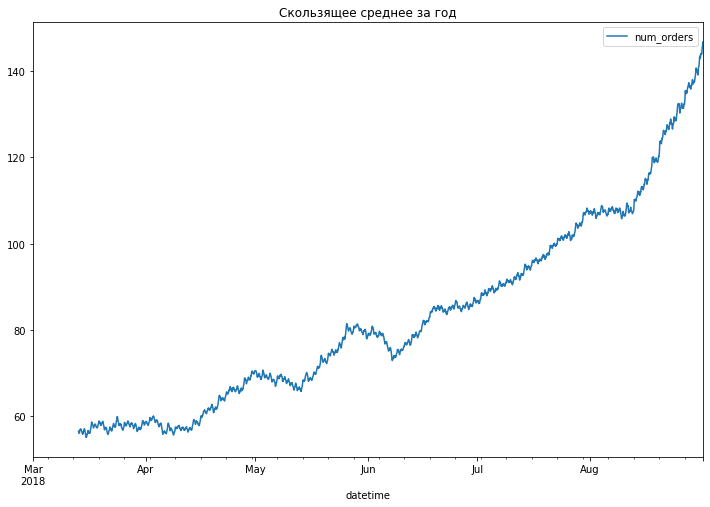

In [10]:
data.rolling(300).mean().plot(figsize=(12,8))
plt.title('Cкользящее среднее за год');

По скользящему более очевилен тренд. Он восходящий, и имеет две точки ускорения начиная с середины апреля и более выраженный рост с августа.

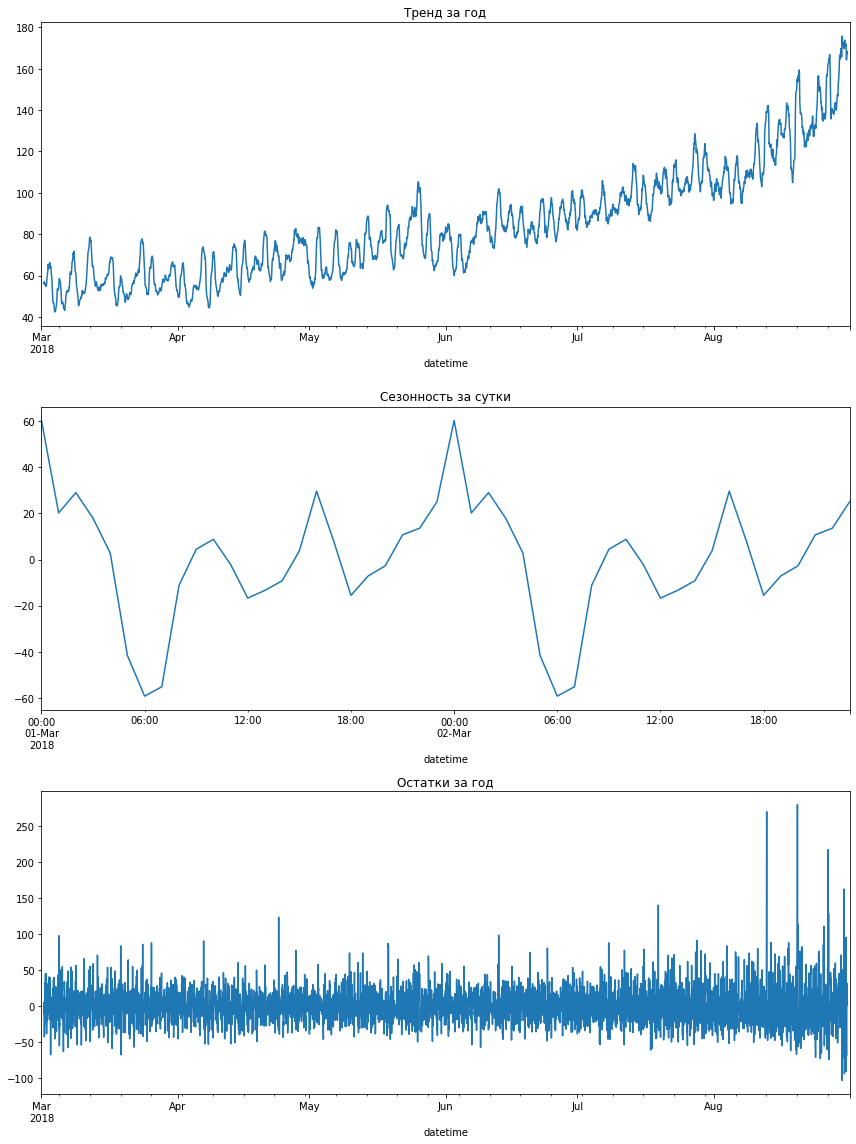

In [11]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 16))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд за год')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca()) 
plt.title('Сезонность за сутки')


plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(),) 
plt.title('Остатки за год')
plt.tight_layout()

Тренд явно возрастающий, видно что с августа интенсивность роста увеличивлась. Очень хорошо показана сезонность за сутки, видно что меньше всего заказов в 6 утра, и пиками в 17:00 (послерабочее время) и 00:00, веротяно связанно с возвратом людей домой после вечерних развлечений. Однако нет различий в буднии и выходные дни(если сделать сезонность за 7 дней) - это говорит о том, что данные вероятно синтетические. Остатки увеличиваются к концу года, в тестовую выборку попадет чуть больше данных, которые сложно объяснить и на которых модели будет сложнее обучиться. Но в целом здесь это не сильно критично.

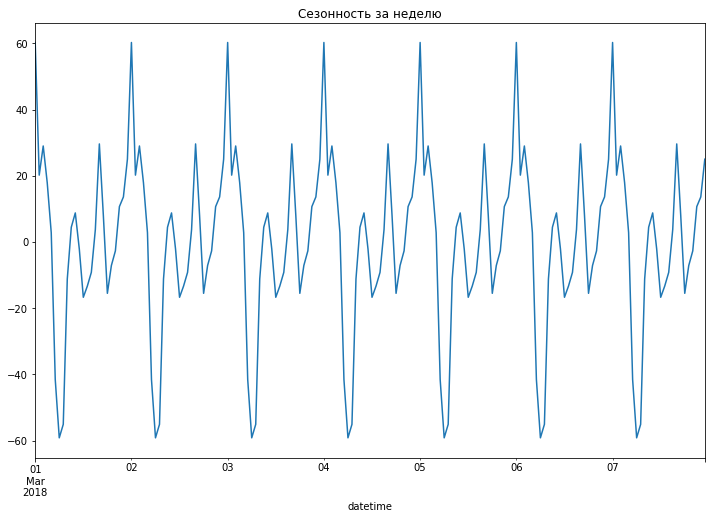

In [12]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca(),figsize=(12,8)) 
plt.title('Сезонность за неделю');

По тренду видно, что количество заказов в такси растет.чОтенько растет.
Судя по сесознному распределению. Стохастический процесс распределения заказов стационарный по месяцам. Но это не точно.

In [13]:

from statsmodels.tsa.stattools import adfuller

ts = data['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')


Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


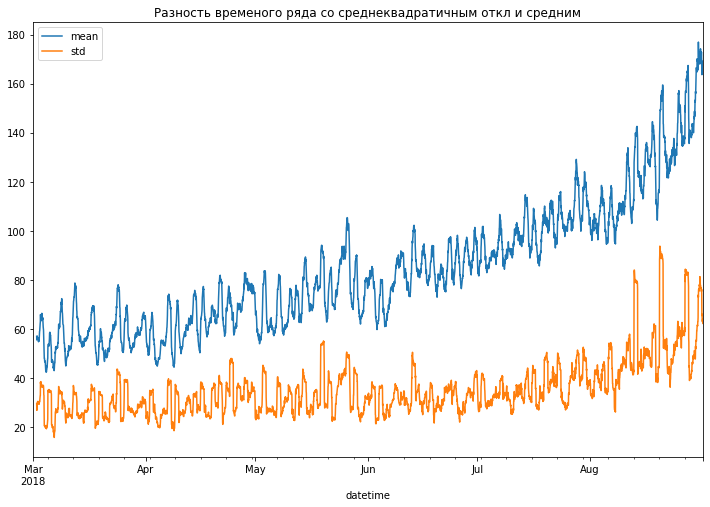

In [14]:
shift_df=data-data.shift()
shift_df['mean'] = data['num_orders'].rolling(24).mean()
shift_df['std'] = data['num_orders'].rolling(24).std()
shift_df.drop(['num_orders'],axis=1).plot(figsize=(12,8))
plt.title('Разность временого ряда со среднеквадратичным откл и средним');

Можно заметить, что хоть и идет рост заказов после августа, но при этом и идет рост среднеквадратичного отклонения

### Вывод:

Тренд явно возрастающий, видно что с августа интенсивность роста увеличивлась. Очень хорошо показана сезонность за сутки, видно что меньше всего заказов в 6 утра, и пиками в 17:00 (послерабочее время) и 00:00, веротяно связанно с возвратом людей домой после вечерних развлечений. Однако нет различий в буднии и выходные дни(если сделать сезонность за 7 дней) - это говорит о том, что данные вероятно синтетические. Остатки увеличиваются к концу года, в тестовую выборку попадет чуть больше данных, которые сложно объяснить и на которых модели будет сложнее обучиться. Но в целом здесь это не сильно критично.

По скользящему более очевилен тренд. Он восходящий, и имеет две точки ускорения начиная с середины апреля и более выраженный рост с августа.

Можно заметить, что хоть и идет рост заказов после августа, но при этом и идет рост среднеквадратичного отклонения

Наш ряд стационарный



## Обучение

### Новые признаки

Создадим доп признаки из датты. Возьмем их из индекса датты.

Создам признаки час, день, день недели, отстающие значения lag, и скользящее среднее

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()



In [16]:
make_features(data, 168, 6)
data=data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 173 entries, num_orders to rolling_mean
dtypes: float64(169), int64(4)
memory usage: 5.6 MB


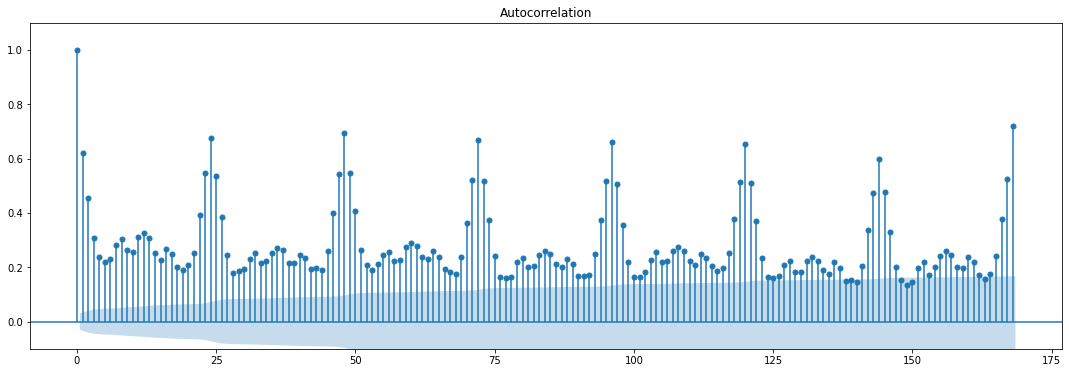

In [17]:
# Код ревьюера
from statsmodels.graphics import tsaplots

fig = tsaplots.plot_acf(data['num_orders'],lags= 168)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



In [18]:
data.head()

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,8,3,94.0,127.0,108.0,76.0,50.0,99.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,92.333333
2018-03-08 01:00:00,78,1,8,3,143.0,94.0,127.0,108.0,76.0,50.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,99.666667
2018-03-08 02:00:00,65,2,8,3,78.0,143.0,94.0,127.0,108.0,76.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,104.333333
2018-03-08 03:00:00,68,3,8,3,65.0,78.0,143.0,94.0,127.0,108.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,102.500000
2018-03-08 04:00:00,60,4,8,3,68.0,65.0,78.0,143.0,94.0,127.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,95.833333


In [19]:
data.describe()

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
count,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,...,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000
mean,85.616996,11.500000,16.305085,3.005650,85.590866,85.568267,85.556262,85.537900,85.517655,85.492232,...,81.859463,81.857815,81.843220,81.816855,81.780838,81.752354,81.731403,81.693503,81.658427,85.543864
std,45.115366,6.923001,8.694656,1.990315,45.078335,45.033473,45.020688,45.008672,45.005310,44.967156,...,42.070918,42.073400,42.086878,42.099302,42.067027,42.036720,42.019888,41.944229,41.846399,32.769627
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.500000
25%,55.750000,5.750000,9.000000,1.000000,55.750000,55.750000,55.750000,55.750000,55.000000,55.000000,...,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,63.625000
50%,80.000000,11.500000,16.000000,3.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,80.166667
75%,109.000000,17.250000,24.000000,5.000000,109.000000,109.000000,109.000000,108.250000,108.000000,108.000000,...,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,103.208333
max,462.000000,23.000000,31.000000,6.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,...,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,272.333333


### Разделение датасета

Выделим фичи и таргеты и разделим на тестовую и обучающую выборку датасет

In [20]:
X=data.drop('num_orders',axis=1)
Y=data['num_orders']
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,shuffle=False,test_size=0.1)

### Обучение модели

In [21]:
rf=RandomForestRegressor(random_state=42)
gbr=GradientBoostingRegressor()
liner_reg=LinearRegression()

tscv = TimeSeriesSplit(n_splits=4)

Проверю модели из коробки.

In [36]:
%%time
rf_pred1=RandomForestRegressor(random_state=42).fit(X_train,Y_train).predict(X_train)
gbr_pred1=GradientBoostingRegressor().fit(X_train,Y_train).predict(X_train)

print(f'Ошибка при обучении модели решающего дерева ={mean_squared_error(Y_train,rf_pred1)**0.5}',
      f'Ошибка при обучении модели Градиентного бустинга = {mean_squared_error(Y_train,gbr_pred1)**0.5}',sep='\n')

Ошибка при обучении модели решающего дерева =8.038384387915189
Ошибка при обучении модели Градиентного бустинга = 16.931067420870747
CPU times: user 38.8 s, sys: 132 ms, total: 38.9 s
Wall time: 38.9 s


In [22]:
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [23]:
def my_custom_loss_func(y_true, y_pred):
    diff = mean_squared_error(y_true, y_pred)
    return diff**0.5
score = make_scorer(my_custom_loss_func, greater_is_better=False)

#### GradientBoostingRegressor

In [28]:
%%time
param_grid2 = {'n_estimators': range(500, 650, 50),
              'max_depth':np.arange(9, 13, 1),
               'learning_rate':[0.01,0.1]}
grd_gbr = RandomizedSearchCV(gbr,cv=tscv,
                             param_distributions=param_grid2, n_jobs=-1,
                             scoring='neg_root_mean_squared_error',verbose=3)


CPU times: user 84 µs, sys: 1e+03 ns, total: 85 µs
Wall time: 67 µs


In [29]:
'''-24.635534833940007 {'n_estimators': 500, 'max_depth': 9, 'learning_rate': 0.01}
CPU times: user 1h 5min 19s, sys: 11 s, total: 1h 5min 30s
Wall time: 1h 5min 37s'''
%%time
grd_gbr.fit(X_train,Y_train)
print(grd_gbr.best_score_,grd_gbr.best_params_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4] END learning_rate=0.1, max_depth=10, n_estimators=500; total time=  32.8s
[CV 2/4] END learning_rate=0.1, max_depth=10, n_estimators=500; total time= 1.0min
[CV 3/4] END learning_rate=0.1, max_depth=10, n_estimators=500; total time= 1.6min
[CV 4/4] END learning_rate=0.1, max_depth=10, n_estimators=500; total time= 2.1min
[CV 1/4] END learning_rate=0.01, max_depth=9, n_estimators=500; total time=  31.1s
[CV 2/4] END learning_rate=0.01, max_depth=9, n_estimators=500; total time=  59.9s
[CV 3/4] END learning_rate=0.01, max_depth=9, n_estimators=500; total time= 1.5min
[CV 4/4] END learning_rate=0.01, max_depth=9, n_estimators=500; total time= 2.0min
[CV 1/4] END learning_rate=0.01, max_depth=10, n_estimators=500; total time=  32.0s
[CV 2/4] END learning_rate=0.01, max_depth=10, n_estimators=500; total time= 1.1min
[CV 3/4] END learning_rate=0.01, max_depth=10, n_estimators=500; total time= 1.7min
[CV 4/4] END learning_r

ммм RandomSearch 1 час 5 минут подбирал параметры, и те хуже линейной регрессии)

Почему отрицательное значения у квадратного корня...

#### RandomForestRegressor

In [42]:
%%time
param_grid = {'n_estimators': range(500, 650, 50),
              'max_depth':np.arange(1, 12, 2),
              'min_samples_split':range(2, 4),
              'min_samples_leaf':range(1, 2)
             }
param_grid_2 = {'n_estimators': range(90, 115, 5),
              'max_depth':np.arange(3, 8, 1),
              'min_samples_split':range(2, 4),
              'min_samples_leaf':range(1, 2)
             }

grd_rf = RandomizedSearchCV(rf,cv=tscv, param_distributions=param_grid_2, n_jobs=-1,scoring='neg_root_mean_squared_error',verbose=100)


CPU times: user 444 µs, sys: 0 ns, total: 444 µs
Wall time: 348 µs


In [40]:
"""-23.022207856287437 {'n_estimators': 550, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 11}
CPU times: user 29min 21s, sys: 4.64 s, total: 29min 26s
Wall time: 29min 28s"""


"-23.022207856287437 {'n_estimators': 550, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 11}\nCPU times: user 29min 21s, sys: 4.64 s, total: 29min 26s\nWall time: 29min 28s"

In [45]:
'''-23.146325251176595 {'n_estimators': 110, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7}
CPU times: user 4min 21s, sys: 526 ms, total: 4min 21s
Wall time: 4min 25s'''

"-23.146325251176595 {'n_estimators': 110, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 7}\nCPU times: user 4min 21s, sys: 526 ms, total: 4min 21s\nWall time: 4min 25s"

In [43]:
%%time
grd_rf.fit(X_train,Y_train)
print(grd_rf.best_score_,grd_rf.best_params_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV 1/4; 1/10] START max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=105
[CV 1/4; 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=105; total time=   2.0s
[CV 2/4; 1/10] START max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=105
[CV 2/4; 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=105; total time=   3.8s
[CV 3/4; 1/10] START max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=105
[CV 3/4; 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=105; total time=   5.5s
[CV 4/4; 1/10] START max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=105
[CV 4/4; 1/10] END max_depth=4, min_samples_leaf=1, min_samples_split=2, n_estimators=105; total time=   7.3s
[CV 1/4; 2/10] START max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=110
[CV 1/4; 2/10] END max_depth=5, min_sam

#### Линейная регрессия

In [30]:
liner_reg.fit(X_train,Y_train)

LinearRegression()

In [35]:
%%time
mean_squared_error(Y_train,liner_reg.fit(X_train,Y_train).predict(X_train))**0.5

CPU times: user 112 ms, sys: 99.9 ms, total: 212 ms
Wall time: 188 ms


20.471727165334432

### Вывод

По итогу обучения моделей, было созданы новые признаки час, день, день недели, отстающие значения lag (168), и скользящее среднее. 
Были обучены три модели : RandomForestRegressor, GradientBoostingRegressor, LinerRegressor. К первым двум был выполнен подбор гипперпараметров.
По итогу получен следующий результат по RMSE:
RandomForestRegressor : 23.02
GradientBoostingRegressor : 24.63
LinerRegressor : 20.47
Линейная регрессия оказалась наилучшей моделью
Как-то я неудачно посчитал гипперпараметры, что модели из коробки показали результат лучше(
Ошибка при обучении модели решающего дерева =8.038384387915189
Ошибка при обучении модели Градиентного бустинга = 16.931067420870747)

## Тестирование

In [32]:
rf_pred=grd_rf.best_estimator_.fit(X_train,Y_train).predict(X_test)
gbr_pred=grd_gbr.best_estimator_.fit(X_train,Y_train).predict(X_test)
lin_pred=liner_reg.predict(X_test)

In [33]:
print(f'Ошибка модели решающего дерева ={mean_squared_error(Y_test,rf_pred)**0.5}',
      f'Ошибка модели Градиентного бустинга = {mean_squared_error(Y_test,gbr_pred)**0.5}',
     f'Ошибка модели Линейной регрессии = {mean_squared_error(Y_test,lin_pred)**0.5}',sep='\n')

Ошибка модели решающего дерева =38.97065741425791
Ошибка модели Градиентного бустинга = 40.70050959537883
Ошибка модели Линейной регрессии = 34.21612393982236


In [46]:
rf_stock_pred=RandomForestRegressor(random_state=42).fit(X_train,Y_train).predict(X_test)
gbr_stock_pred=GradientBoostingRegressor().fit(X_train,Y_train).predict(X_test)
print(f'Ошибка модели решающего дерева ={mean_squared_error(Y_test,rf_stock_pred)**0.5}',
      f'Ошибка модели Градиентного бустинга = {mean_squared_error(Y_test,gbr_stock_pred)**0.5}',sep='\n')

Ошибка модели решающего дерева =38.927984042935734
Ошибка модели Градиентного бустинга = 38.11955553577225


### Вывод:

По итогу тестирования имеем наименьшую ошибку у Линейной регрессии RMSE=34.2, остальные модели получились менее эффективными.
Ошибка модели Градиентного бустинга = 40.7
Ошибка модели Линейной регрессии = 34.21

## Вывод

По итогу проекта, был проанализирован временной ряд заказов в такси за год. Выборка была разбита на тестовую и учебну без перемешивания. После разбития были обучены 3 модели: Решающий лес, Градиентный бустинг, линейная регресиия. К первым двум были подобраны гипперпараметры. По итогу обучения и тестирования было решено, что наилучшая модель для решения данной задачи - Линейная реграссия, с ошибкой RMSE на тесте 34.21